Before running the code blocks, run the following commands to get the kernel prepared:
```sh
julia
import Pkg
Pkg.update()
Pkg.precompile()

using Pkg
Pkg.build("IJulia")
```

In [10]:
using HDF5
using Serialization
using DataFrames, Plots
using Plots.PlotMeasures 

In [11]:
function timer_dict_to_df(timer_dict)
    rows = []

    for (trial, ranks) in timer_dict
        n_important_prt, total_rank, nprt_per_rank = split(trial, ":")
        trial_name = "$n_important_prt particles most weights"
        for (rank, timers) in ranks
            for (op, metrics) in timers["inner_timers"]
                for (metric, value) in metrics
                    if metric == "time_ns"
                        value = value / 1e6 # convert to milliseconds
                        metric = "time_ms"
                    end
                    push!(rows, (
                        trial  = String(trial_name),
                        total_rank = parse(Int, total_rank),
                        thread_per_rank = 1,
                        nprt_per_rank = nprt_per_rank,
                        rank   = rank,
                        op     = String(op),
                        metric = String(metric),
                        value  = value,
                    ))
                end
            end
        end
    end
    return DataFrame(rows)
end

timer_dict_to_df (generic function with 1 method)

In [12]:
root = dirname(@__FILE__)
h5path(rank) = joinpath(root, "../test/output", "all_timers_$(rank).h5") 

# 1) read the raw byte‐blob from disk, automatically closing the file
all_timer_dfs = DataFrame()
for rank in [1, 2]
    blob = h5open(h5path(rank)) do f
        read(f, "all_timers")
    end

    # 2) deserialize back into Dict{String,Dict{Int,Dict{String,Any}}}
    merged_timers = deserialize(IOBuffer(blob))

    # 3) convert to DataFrame
    timer_df = timer_dict_to_df(merged_timers)
    
    # 4) concat to all_timer_dfs
    all_timer_dfs = vcat(all_timer_dfs, timer_df)
end


In [ ]:
# -- 2) Example: assume `timer_dict` is already in your workspace
println(all_timer_dfs)  # print all trial names

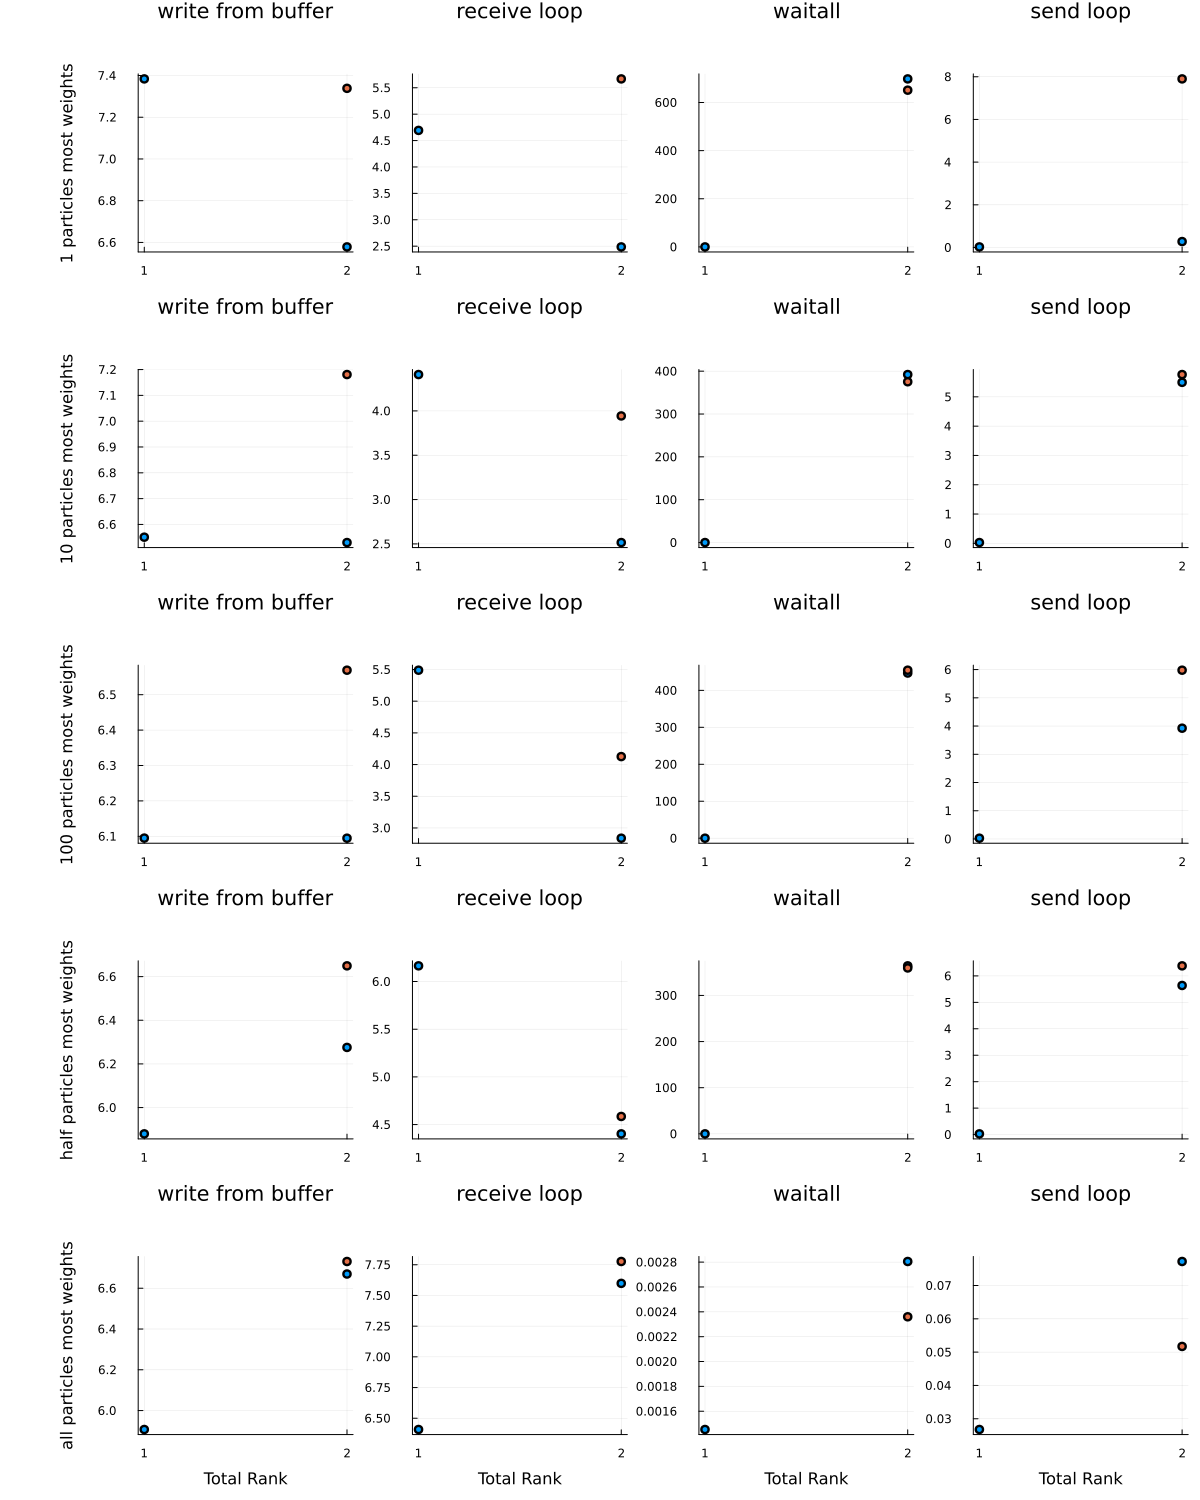

In [14]:
# 1) Filter & rename to just the ms timings
df_ms = filter(row -> row.metric == "time_ms", all_timer_dfs)
rename!(df_ms, :value => :time_ms)

trials = unique(df_ms.trial)
ops    = unique(df_ms.op)

ntrials, nops = length(trials), length(ops)

# 2) Create an empty grid, with row & column titles
plt = plot(
  layout     = (ntrials, nops),
  legend     = :none,              # turn off the per-rank legend
  size       = (300 * nops, 300 * ntrials),
)

# 3) Fill it in
for (i, trial) in enumerate(trials)
  for (j, op) in enumerate(ops)
    sub = df_ms[(df_ms.trial .== trial) .& (df_ms.op .== op), :]
    for rk in unique(sub.rank)
      subrk = sub[sub.rank .== rk, :]
      scatter!(
        plt[i, j],
        string.(subrk.total_rank),    # categorical x
        subrk.time_ms;
        marker     = :circle,
        markersize = 4,
        label      = false,
      )
    end
    plot!(plt[i, j], title = string(op), top_margin = 10mm)
    if j == 1
      plot!(plt[i, j], ylabel = string(trial), left_margin = 20mm)
    end

    # only the bottom row gets the shared x‐axis label
    if i == ntrials
      plot!(plt[i, j], xlabel = "Total Rank")
    end
  end
end

display(plt)